In [508]:
from numpy import array
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import NearestNDInterpolator
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset

In [509]:
hafs_set = Dataset("test_v2_out.nc")

In [510]:
nyquist_freq = 10

In [511]:
##Calculate the number of folds for each gate in the wind field. 
def fold(v, nyquist = nyquist_freq):

    if np.isnan(v):
        return(np.nan)
     
    if np.abs(v) <= nyquist_freq:
        return v
    else:
        ##Folded 
        rem = np.abs(v) % nyquist 
        vsign = np.sign(v) 
        ###Even number of folds 
        if (((np.abs(v) // nyquist_freq) % 2) == 0) :
            v_folded = (-1 * vsign * nyquist) + (vsign * (rem + nyquist))
            return(v_folded)
        else:
            ###Odd number of multiples of nyquist freq 
            v_folded = (-1 * vsign * nyquist) + (vsign * rem)
            return(v_folded)
        
    


array([[[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        ...,
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36]],

       [[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
         9.96921e+36, 9.96921e+36],
        ...,
        [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9

In [521]:
def write_aliased_doppler_velocities(radar_path, hafs_path="test_v2_out.nc"):

        hafs_set = Dataset(hafs_path)
        lats = hafs_set["lat"][:].data
        lons = hafs_set["lon"][:].data
        levs = hafs_set["isobaricInhPa"][:].data
        
        hafs_lats = hafs_set["lat"][:]
        hafs_lons = hafs_set["lon"][:]
        u = hafs_set["u"][0,:,:,:]
        v = hafs_set["v"][0,:,:,:]
        w = hafs_set["w"][0,:,:,:]


        u_interp_grid = rgi((levs, hafs_lats, hafs_lons), u)
        v_interp_grid = rgi((levs, hafs_lats, hafs_lons), v)
        w_interp_grid = rgi((levs, hafs_lats, hafs_lons), w)


        radar_dat = Dataset(sample_cfrad_path, "a")

        geopotential_height_field = hafs_set["gh"][0,:,:,:].data
        hl = radar_dat["CLOSEST_HAFS_LAT"][:]
        hln = radar_dat["CLOSEST_HAFS_LON"][:]
        hz = radar_dat["NEW_Z_METERS"][:]

        curr_interp = ""
        z=""

        vector_winds = []
        u_winds = [] 
        v_winds = [] 
        w_winds = [] 


        for (latidx, lonidx, z) in zip(hl, hln, hz):
                try: 
                        if z < 0:
                                vector_winds.append(-1)
                                continue
                        curr_interp = rgi((geopotential_height_field[:, latidx, lonidx].data,),levs )
                        curr_isobaric = curr_interp([z])[0]
                        
                        curr_lat = hafs_lats[latidx]
                        curr_lon = hafs_lons[lonidx]              
                        curr_u = u_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                        curr_v = v_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                        curr_w = w_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                        vector_winds.append((curr_u, curr_v, curr_w))
                        u_winds.append(curr_u)
                        v_winds.append(curr_v) 
                        w_winds.append(curr_w)
                except: 
                        u_winds.append(-32000)
                        vector_winds.append(-1)

        dx = radar_dat["dx"][:].data
        dy = radar_dat["dy"][:].data
        dz = radar_dat["dz"][:].data

        dir_vecs = [] 
        for x, y, z in zip(dx, dy, dz): 
                dir_vector = [x, y, z] / np.linalg.norm([x, y, z])
                dir_vecs.append(dir_vector)

        dop_winds = []
        for wind, dir in zip(vector_winds, dir_vecs): 
                wind = np.dot(wind, dir) * dir
                dop_winds.append(np.linalg.norm(wind))

        folded_dop_winds = [] 
        for wind in dop_winds:
                folded_dop_winds.append(fold(wind))

        radar_dat.createVariable("doppler_winds", "f", ("n_points", ))
        radar_dat["doppler_winds"][:] = dop_winds

        radar_dat.createVariable("folded_doppler_winds", "f", ("n_points", ))
        radar_dat["folded_doppler_winds"][:] = folded_dop_winds 


In [512]:
lats = hafs_set["lat"][:].data
lons = hafs_set["lon"][:].data
levs = hafs_set["isobaricInhPa"][:].data

In [513]:
latgrid = np.reshape(np.repeat(lats, len(lons)), (len(lats), len(lons)))
longrid = np.reshape(np.repeat(lons, len(lats)), (len(lats), len(lons)))

In [417]:
sample_cfrad_path = "/Users/ischluesche/Documents/Grad_School/Research/julia_grib/g_alias.jl/cfrads/cfrad.20220918_105940.889_to_20220918_105944.869_N42RF-TS_AIR.nc"

In [515]:
radar_dat = Dataset(sample_cfrad_path, "a")

In [420]:
hafs_lats = hafs_set["lat"][:]
hafs_lons = hafs_set["lon"][:]
u = hafs_set["u"][0,:,:,:]
v = hafs_set["v"][0,:,:,:]
w = hafs_set["w"][0,:,:,:]


u_interp_grid = rgi((levs, hafs_lats, hafs_lons), u)
v_interp_grid = rgi((levs, hafs_lats, hafs_lons), v)
w_interp_grid = rgi((levs, hafs_lats, hafs_lons), w)

In [425]:
hl = radar_dat["CLOSEST_HAFS_LAT"][:]
hln = radar_dat["CLOSEST_HAFS_LON"][:]
hz = radar_dat["NEW_Z_METERS"][:]


In [430]:
isobaric_pressures = []
curr_interp = ""
lat =""
lon=""
z=""

vector_winds = []
u_winds = [] 
v_winds = [] 
w_winds = [] 
isobaric_levs = []

for (latidx, lonidx, z) in zip(hl, hln, hz):
        try: 
                if z < 0:
                        vector_winds.append(-1)
                        continue
                curr_interp = rgi((geopotential_height_field[:, latidx, lonidx].data,),levs )
                curr_isobaric = curr_interp([z])[0]
                isobaric_levs.append(curr_isobaric)
                
                curr_lat = hafs_lats[latidx]
                curr_lon = hafs_lons[lonidx]              
                curr_u = u_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                curr_v = v_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                curr_w = v_interp_grid([curr_isobaric, curr_lat, curr_lon])[0]
                vector_winds.append((curr_u, curr_v, curr_w))
                u_winds.append(curr_u)
                v_winds.append(curr_v) 
                w_winds.append(curr_w)
        except: 
                u_winds.append(-32000)
                vector_winds.append(-1)


In [516]:
dx = radar_dat["dx"][:].data
dy = radar_dat["dy"][:].data
dz = radar_dat["dz"][:].data

dir_vecs = [] 
for x, y, z in zip(dx, dy, dz): 
    dir_vector = [x, y, z] / np.linalg.norm([x, y, z])
    dir_vecs.append(dir_vector)

dop_winds = []
for wind, dir in zip(vector_winds, dir_vecs): 
    wind = np.dot(wind, dir) * dir
    dop_winds.append(np.linalg.norm(wind))

folded_dop_winds = [] 
for wind in dop_winds:
    folded_dop_winds.append(fold(wind))

/var/folders/8d/nm74387d25q_yszbyg7xlqn40000gn/T/ipykernel_55905/2684576163.py:7: RuntimeWarning: invalid value encountered in divide
  dir_vector = [x, y, z] / np.linalg.norm([x, y, z])


In [464]:
dop_winds = []
for wind, dir in zip(vector_winds, dir_vecs): 
    wind = np.dot(wind, dir) * dir
    dop_winds.append(np.linalg.norm(wind))


In [465]:
dop_winds

[nan,
 0.14972341758410135,
 0.1390690950837357,
 0.12841483382196486,
 0.11776045008300506,
 0.0906300506788782,
 0.0018807761805736932,
 0.0943917167170702,
 0.18690237566320045,
 0.2794131138649574,
 0.45290522468335664,
 0.6661853206330695,
 0.8794654918378806,
 1.092745699015727,
 1.3062154976898213,
 1.5452672105052832,
 1.7843189349329605,
 2.0233711439861546,
 2.2624228915696203,
 2.4799219282118523,
 2.6117892386701262,
 2.7436562695066176,
 2.8755228445226195,
 3.0073903584349075,
 3.097371670411028,
 3.0467781369542837,
 2.996184659736561,
 2.945591064623709,
 2.8949973164477476,
 2.8468872980431654,
 2.829613064119257,
 2.599896669095096,
 2.569613973730529,
 2.5393315059008406,
 2.509048745051787,
 2.540774090178758,
 2.599052585045708,
 2.65733088172557,
 2.7156091214020077,
 2.7738873378587363,
 2.843672565962827,
 2.9967844490657667,
 3.149897774790014,
 3.3030105280012574,
 3.456122318806837,
 3.609235737329597,
 3.748716307697401,
 3.8608523225402718,
 3.9729891073127

In [454]:
dx

array([   -0.        ,    -4.85035372,    -9.70070744, ...,
       -4142.9921875 , -4148.76220703, -4154.53271484])

In [450]:
missing

NameError: name 'missing' is not defined

In [449]:
np.linalg.norm([0,2,3])

3.605551275463989

In [447]:
[1,2,3] / np.linalg.norm([1,2,3])

array([0.26726124, 0.53452248, 0.80178373])

In [448]:
np.sqrt(.26**2 + .53**2 + .8**2)

0.9942333730065593

In [441]:
unit_vecs = [] 
for trio in zip(dx, dy, dz):
    unit_vecs.append((dx/dx, dy/dy, dz/dz))

/var/folders/8d/nm74387d25q_yszbyg7xlqn40000gn/T/ipykernel_55905/4288066667.py:3: RuntimeWarning: invalid value encountered in divide
  unit_vecs.append((dx/dx, dy/dy, dz/dz))


KeyboardInterrupt: 

In [440]:
[dx, dy, dz]

[array([   -0.        ,    -4.85035372,    -9.70070744, ...,
        -4142.9921875 , -4148.76220703, -4154.53271484]),
 array([    -0.        ,    -38.27749634,    -76.55499268, ...,
        -26977.28320312, -27014.85546875, -27052.4296875 ]),
 array([    0.        ,    64.31412506,   128.62825012, ...,
        46420.734375  , 46485.38671875, 46550.0390625 ])]

In [393]:
i = 30
curl = hl[721*i:721*(i+1)].data
curln = hln[721*i:721*(i+1)].data 
currz = hz[721*i:721*(i+1)].data

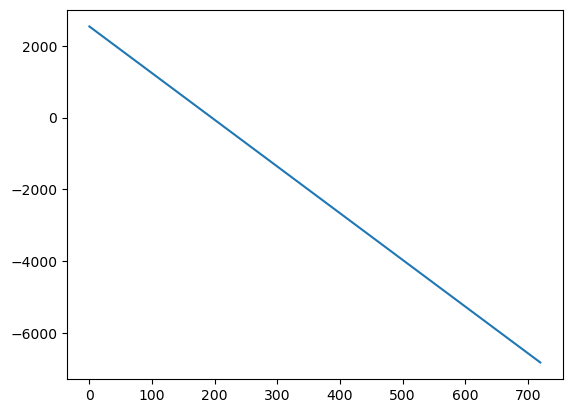

In [394]:
plt.plot(currz)

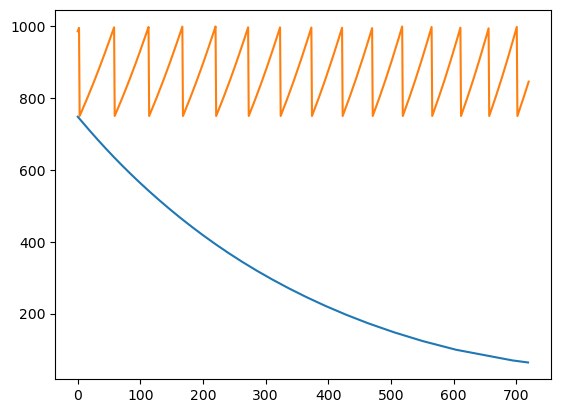

In [384]:
plt.plot(isobaric_levs[1:721])
plt.plot(isobaric_levs[721*30:721*31])

In [380]:
vector_winds

[(-9.963693640158223, -10.851331994033691, -10.851331994033691),
 (-9.683078741280493, -10.83864712678499, -10.83864712678499),
 (-9.382458552572809, -10.83699985521511, -10.83699985521511),
 (-9.08183838843436, -10.835352583779859, -10.835352583779859),
 (-8.781218175157404, -10.83370531207535, -10.83370531207535),
 (-9.055168277794731, -10.978664006536285, -10.978664006536285),
 (-8.761153809825148, -10.963839723226519, -10.963839723226519),
 (-8.467139149620232, -10.9490154302242, -10.9490154302242),
 (-8.173124681650634, -10.934191146914433, -10.934191146914433),
 (-7.879110021445752, -10.919366853912116, -10.919366853912116),
 (-7.585095553476153, -10.90454257060235, -10.90454257060235),
 (-7.291080893271254, -10.88971827760003, -10.88971827760003),
 (-6.99706661753694, -10.874894003982817, -10.874894003982817),
 (-6.79741450441564, -10.972048392584838, -10.972048392584838),
 (-6.64426927559305, -11.124391833944042, -11.124391833944042),
 (-6.491124046770459, -11.276735275303242, 

In [354]:
isobaric_levs

[]

In [397]:
wind_mag = [np.sqrt(itm[0]**2 + itm[1] ** 2 + itm[2] ** 2) if itm != -1 else -1000 for itm in vector_winds]

In [272]:
np.shape(wind_mag)

(257963,)

In [273]:
np.shape(u_winds)

(257963,)

In [468]:
radar_dat.createVariable("doppler_winds", "f", ("n_points", ))

<class 'netCDF4._netCDF4.Variable'>
float32 doppler_winds(n_points)
unlimited dimensions: 
current shape = (257962,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [469]:
radar_dat.createVariable("doppler_winds", "f", ("n_points", ))
radar_dat["doppler_winds"][:] = dop_winds

In [470]:
radar_dat.close()

In [275]:
radar_dat["modeled_u_wind"][:] = u_winds

In [400]:
radar_dat["modeled_wind_mag"][:] = wind_mag

In [401]:
radar_dat.close()

[(-4.861959956222972, 1.7424917925403283, 1.7424917925403283)]